## PART 1: Generate Daily Sentiment Embeddings (CLS / Mean / Max)

In [4]:
# Install dependencies
#!pip install transformers datasets tensorflow pandas numpy
#!pip install datasets
#!pip install --upgrade numpy
#!pip install --upgrade gensim

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import defaultdict
import nltk
nltk.download("punkt")
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

output_dir = "/content/drive/MyDrive/DataSci266_Final_Project/FinWord_Word2Vec_embeddings"
os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
!pip install ta
from ta import add_all_ta_features

market_path = "/content/drive/MyDrive/DataSci266_Final_Project/yahoo_finance_historical_data_10year.csv"
sentiment_path = "/content/drive/MyDrive/DataSci266_Final_Project/finbert_embeddings/daily_sentiment_embeddings.pkl"
results_dir = "/content/drive/MyDrive/DataSci266_Final_Project/combined_multiple_embeddings_lstm_results"
os.makedirs(results_dir, exist_ok=True)

# Load sentiment
with open(sentiment_path, "rb") as f:
    sentiment_df = pickle.load(f)

print("📂 Type of loaded object:", type(sentiment_df))
print("📋 Columns:", sentiment_df.columns)
print("🔍 Sample rows:")
print(sentiment_df.head())

# Force re-parse the date column
sentiment_df = pd.read_pickle(sentiment_path)

# Convert to string first (in case of objects), then to datetime
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"].astype(str), errors='coerce')

# Drop any invalid dates
sentiment_df = sentiment_df.dropna(subset=["date"])

# Add lagged sentiment features
sentiment_df["cls_shift_1"] = sentiment_df["cls"].shift(1)
sentiment_df["cls_momentum"] = sentiment_df["cls"] - sentiment_df["cls_shift_1"]

# Confirm it worked
print("✅ Fixed Sentiment dates:", sentiment_df["date"].min(), "→", sentiment_df["date"].max())

📂 Type of loaded object: <class 'pandas.core.frame.DataFrame'>
📋 Columns: Index(['date', 'cls', 'mean', 'max', 'avg_sentiment'], dtype='object')
🔍 Sample rows:
          date                                                cls  \
441 2021-12-27  [-0.23162088, -0.537831, -0.11581464, 0.582418...   
440 2022-01-02  [-0.22748329, -0.61845094, -0.04058229, 0.4155...   
439 2022-01-03  [-0.15400232, -0.5237716, -0.059607867, 0.4547...   
438 2022-01-04  [-0.17182718, -0.5494433, -0.0702886, 0.569090...   
437 2022-01-05  [-0.11933209, -0.53722817, -0.1544225, 0.46808...   

                                                  mean  \
441  [-0.39374432, -0.44676203, -0.3779505, 0.55620...   
440  [-0.45924956, -0.51103616, -0.19575621, 0.3937...   
439  [-0.34352374, -0.42859635, -0.23460747, 0.4499...   
438  [-0.35483292, -0.42010704, -0.23844147, 0.4636...   
437  [-0.3026388, -0.44002488, -0.29311842, 0.45087...   

                                                   max  avg_sentiment  
441 

In [3]:
market_df = pd.read_csv(market_path, skiprows=[1, 2])
market_df = market_df.rename(columns={"Price": "Date"})
market_df["Date"] = pd.to_datetime(market_df["Date"])

tickers = market_df.iloc[0, 1::5].values
market_df = market_df[2:]

data = []
for i, ticker in enumerate(tickers):
    try:
        df = pd.DataFrame({
            "Date": market_df["Date"],
            "Ticker": ticker,
            "Close": market_df[f"Close.{i}"].astype(float),
            "Open": market_df[f"Open.{i}"].astype(float),
            "High": market_df[f"High.{i}"].astype(float),
            "Low": market_df[f"Low.{i}"].astype(float),
            "Volume": market_df[f"Volume.{i}"].astype(float),
        })
        df["Next_Close"] = df["Close"].shift(-1)
        df["Return"] = (df["Next_Close"] - df["Close"]) / df["Close"]
        # Add engineered features
        df["ret_1"] = df["Return"].shift(1)
        df["ret_3"] = df["Return"].rolling(3).mean()
        df["ret_5"] = df["Return"].rolling(5).mean()
        df["ret_vol_5"] = df["Return"].rolling(5).std()
        df["ret_ratio_5"] = df["ret_5"] / (df["ret_vol_5"] + 1e-6)
        df = df.dropna()
        data.append(df)
    except:
        continue

market_long = pd.concat(data)
market_long = market_long.groupby("Ticker").apply(lambda x: add_all_ta_features(
    x, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)).reset_index(drop=True)

# Filter dates to sentiment range
start_date = sentiment_df["date"].min()
end_date = sentiment_df["date"].max()
market_long = market_long[(market_long["Date"] >= start_date) & (market_long["Date"] <= end_date)]
# Merge with sentiment
combined = market_long.merge(sentiment_df, left_on="Date", right_on="date").drop(columns=["date"])
print("Combined data shape:", combined.shape)
print("Date range:", combined["Date"].min(), "to", combined["Date"].max())

with open("/content/drive/MyDrive/DataSci266_Final_Project/finbert_embeddings/combined_dataset_with_avg_sentiment.pkl", "wb") as f:
    pickle.dump(combined, f)

<ipython-input-3-eec08ecc7e74>:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  market_long = market_long.groupby("Ticker").apply(lambda x: add_all_ta_features(


Combined data shape: (1212, 106)
Date range: 2021-12-27 00:00:00 to 2023-12-22 00:00:00


In [8]:
!pip install nltk
import nltk
nltk.download('punkt_tab')
df = pd.read_csv("/content/sample_data/filtered_5_companies.csv")

tweets_tokenized_by_day = defaultdict(list)

for _, row in df.iterrows():
    text = row.get("description")
    timestamp = row.get("timestamp")
    if pd.isna(text) or pd.isna(timestamp):
        continue

    # Parse date only
    date = timestamp.split("T")[0]

    # Clean and tokenize
    cleaned = re.sub(r"http\\S+|[^\\w\\s$]", "", text.lower())
    tokens = word_tokenize(cleaned)
    if tokens:
        tweets_tokenized_by_day[date].append(tokens)

# Save to .pkl
with open("tweets_tokenized_by_day.pkl", "wb") as f:
    pickle.dump(tweets_tokenized_by_day, f)

print(f"✅ Tokenized {len(tweets_tokenized_by_day)} days of tweets")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Tokenized 441 days of tweets


In [6]:
# Parameters
window = 10
binary = False
embedding_types = ["cls", "mean", "max", "w2v", "googlenews"]
feature_modes = ["price-only", "sentiment-only", "combined"]
models = ["dense", "lstm"]

In [7]:
# Load combined dataset
with open("/content/drive/MyDrive/DataSci266_Final_Project/finbert_embeddings/combined_dataset_with_avg_sentiment.pkl", "rb") as f:
    combined = pickle.load(f)

# Load FinTwitBERT daily embeddings from pkl
with open("/content/drive/MyDrive/DataSci266_Final_Project/finbert_embeddings/daily_sentiment_embeddings.pkl", "rb") as f:
    bert_df = pickle.load(f)

bert_df["date"] = pd.to_datetime(bert_df["date"])
combined["Date"] = pd.to_datetime(combined["Date"])
combined = combined.merge(bert_df, left_on="Date", right_on="date", how="left").drop(columns="date")
combined = combined.rename(columns={
    "cls_y": "cls", "mean_y": "mean", "max_y": "max", "avg_sentiment_y": "avg_sentiment"
}).drop(columns=["cls_x", "mean_x", "max_x", "avg_sentiment_x"], errors="ignore")

In [9]:
# Load tokenized tweets and train custom Word2Vec
with open("/content/tweets_tokenized_by_day.pkl", "rb") as f:
    tweets_by_day = pickle.load(f)

from gensim.models import Word2Vec
all_tokens = [tw for day in tweets_by_day.values() for tw in day]
w2v_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=3, workers=4)

In [33]:
import gzip
import shutil

# Replace 'your_uploaded_file.bin.gz' with the actual filename
with gzip.open('/content/GoogleNews-vectors-negative300.bin.gz', 'rb') as f_in:
    with open('/content/GoogleNews-vectors-negative300.bin', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("✅ Model unzipped successfully!")

✅ Model unzipped successfully!


In [10]:
from gensim.models import KeyedVectors

file_path = "/content/GoogleNews-vectors-negative300.bin"  # Path to the unzipped file
gnews_model = KeyedVectors.load_word2vec_format(file_path, binary=True)

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [13]:
# Generate daily embeddings from GoogleNews Word2Vec
googlenews_daily = daily_embedding_from_model(gnews_model, tweets_by_day)

# Convert to DataFrame
googlenews_df = pd.DataFrame({
    "date": list(googlenews_daily.keys()),
    "googlenews": list(googlenews_daily.values())
})
googlenews_df["date"] = pd.to_datetime(googlenews_df["date"])

# Merge with combined
combined = combined.merge(googlenews_df, left_on="Date", right_on="date", how="left").drop(columns=["date"])

In [14]:
w2v_daily = daily_embedding_from_model(w2v_model.wv, tweets_by_day)
w2v_df = pd.DataFrame({
    "date": list(w2v_daily.keys()),
    "w2v": list(w2v_daily.values())
})
w2v_df["date"] = pd.to_datetime(w2v_df["date"])
combined = combined.merge(w2v_df, left_on="Date", right_on="date", how="left").drop(columns=["date"])
# Keep only the most recent embeddings (usually the _y columns)
combined = combined.rename(columns={
    "w2v_y": "w2v",
    "googlenews_y": "googlenews"
}).drop(columns=["w2v_x", "googlenews_x"], errors="ignore")
combined = combined.loc[:, ~combined.columns.duplicated()]


In [12]:
# Function to aggregate tweet embeddings per day
def daily_embedding_from_model(model, tweets_by_day):
    daily = {}
    for date, tweets in tweets_by_day.items():
        vecs = []
        for tokens in tweets:
            v = [model[w] for w in tokens if w in model]
            if v:
                vecs.append(np.mean(v, axis=0))
        if vecs:
            daily[date] = np.mean(vecs, axis=0)
    return daily

In [51]:
# Compute and merge daily embeddings from Word2Vec models
for key, model in zip(["w2v", "googlenews"], [w2v_model.wv, gnews_model]):
    emb = daily_embedding_from_model(model, tweets_by_day)
    df = pd.DataFrame({"date": list(emb.keys()), key: list(emb.values())})
    df["date"] = pd.to_datetime(df["date"])
    combined = combined.merge(df, left_on="Date", right_on="date", how="left").drop(columns="date")

In [15]:
def safe_stack(vectors, expected_dim):
    clean = []
    for v in vectors:
        if isinstance(v, (np.ndarray, list)) and len(v) == expected_dim:
            clean.append(np.array(v))
    return np.stack(clean) if clean else np.empty((0, expected_dim))

## STEP 3: Create Sequences for LSTM

In [20]:
# Feature prep
def create_sequences(df, sentiment_key, mode="combined", window=10, binary=False):
    def safe_stack(vectors, expected_dim):
        clean = [np.array(v) for v in vectors if isinstance(v, (list, np.ndarray)) and len(v) == expected_dim]
        return np.stack(clean) if clean else np.empty((0, expected_dim))

    # Determine embedding dimensions
    expected_dim = 300 if sentiment_key == "googlenews" else 100 if sentiment_key == "w2v" else df[sentiment_key].iloc[0].shape[0]

    # Safely stack sentiment embeddings
    sentiment = safe_stack(df[sentiment_key].dropna().values, expected_dim)
    if sentiment.shape[0] < window:
        raise ValueError(f"⚠️ Not enough valid vectors for {sentiment_key} ({sentiment.shape[0]} rows)")

    # Use fixed market feature list (consistent across tickers)
    excluded = ["Return", "Next_Close", "avg_sentiment", "Ticker", "Date",
                "cls", "mean", "max", "w2v", "googlenews"]
    market_features = [col for col in df.columns if col not in excluded and df[col].dtype != 'O']

    price = df[market_features].values
    scaler = StandardScaler()
    price_scaled = scaler.fit_transform(price)

    # Align lengths
    min_len = min(len(sentiment), len(price_scaled))
    sentiment = sentiment[:min_len]
    price_scaled = price_scaled[:min_len]

    # Assemble final input features
    if mode == "price-only":
        X_full = price_scaled
    elif mode == "sentiment-only":
        X_full = sentiment
    else:
        sentiment_feat = sentiment
        if "avg_sentiment" in df:
            avg_sent = df["avg_sentiment"].values[:len(sentiment)].reshape(-1, 1)
            sentiment_feat = np.concatenate([sentiment_feat, avg_sent[:min_len]], axis=1)
        X_full = np.concatenate([sentiment_feat[:min_len], price_scaled[:min_len]], axis=1)

    # Create windowed sequences
    X_seq, y = [], []
    for i in range(len(X_full) - window - 1):
        X_seq.append(X_full[i:i+window])
        ret = df["Return"].iloc[i + window]
        y.append(int(ret > 0) if binary else ret)

    return np.array(X_seq), np.array(y)

In [17]:
# Model builders
def build_dense(input_shape):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(1 if not binary else 1, activation='sigmoid' if binary else None)
    ])

def build_lstm(input_shape):
    return tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.LSTM(32, dropout=0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1 if not binary else 1, activation='sigmoid' if binary else None)
    ])

##STEP 4: Train Dense + LSTM Per Embedding & Ticker

In [21]:
# Run model comparisons
results = []
for feature_mode in feature_modes:
    for embedding_key in embedding_types:
        for model_type in models:
            for ticker in tqdm(combined['Ticker'].unique(), desc=f"{feature_mode}-{embedding_key}-{model_type}"):
                df_t = combined[combined['Ticker'] == ticker].copy()
                try:
                    X_seq, y = create_sequences(df_t, embedding_key, mode=feature_mode)
                    if len(X_seq) < 50:
                        continue

                    split = int(0.8 * len(X_seq))
                    X_train, X_test = X_seq[:split], X_seq[split:]
                    y_train, y_test = y[:split], y[split:]

                    if model_type == "dense":
                        X_train_flat = X_train.reshape(X_train.shape[0], -1)
                        X_test_flat = X_test.reshape(X_test.shape[0], -1)
                        model = build_dense(X_train_flat.shape[1])
                        X_tr, X_te = X_train_flat, X_test_flat
                    else:
                        model = build_lstm(X_train.shape[1:])
                        X_tr, X_te = X_train, X_test

                    model.compile(optimizer='adam', loss='mae')
                    model.fit(X_tr, y_train, epochs=10, batch_size=32, verbose=0)
                    y_pred = model.predict(X_te).flatten()

                    mae = mean_absolute_error(y_test, y_pred)
                    acc = accuracy_score(y_test > 0, y_pred > 0)
                    results.append({"Model": model_type.upper(), "Embedding": embedding_key, "FeatureSet": feature_mode, "MAE": mae, "Accuracy": acc})

                except Exception as e:
                    print(f"⚠️ {ticker} failed for {embedding_key}: {e}")

# Save results
result_df = pd.DataFrame(results)
result_df.to_csv("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/final_model_comparison_all_embeddings.csv", index=False)

price-only-cls-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


price-only-cls-dense:  25%|██▌       | 1/4 [00:03<00:09,  3.25s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


price-only-cls-dense:  50%|█████     | 2/4 [00:05<00:05,  2.55s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


price-only-cls-dense:  75%|███████▌  | 3/4 [00:07<00:02,  2.31s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


price-only-cls-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step


price-only-cls-lstm:  25%|██▌       | 1/4 [00:05<00:17,  5.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


price-only-cls-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.33s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


price-only-cls-lstm:  75%|███████▌  | 3/4 [00:15<00:05,  5.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


price-only-mean-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


price-only-mean-dense:  25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


price-only-mean-dense:  50%|█████     | 2/4 [00:03<00:03,  1.93s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


price-only-mean-dense:  75%|███████▌  | 3/4 [00:05<00:01,  1.99s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


price-only-mean-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


price-only-mean-lstm:  25%|██▌       | 1/4 [00:05<00:16,  5.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


price-only-mean-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


price-only-mean-lstm:  75%|███████▌  | 3/4 [00:16<00:05,  5.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


price-only-max-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


price-only-max-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.29s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


price-only-max-dense:  50%|█████     | 2/4 [00:05<00:05,  2.72s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


price-only-max-dense:  75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


price-only-max-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


price-only-max-lstm:  25%|██▌       | 1/4 [00:04<00:14,  4.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


price-only-max-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


price-only-max-lstm:  75%|███████▌  | 3/4 [00:15<00:05,  5.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


price-only-w2v-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


price-only-w2v-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.15s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


price-only-w2v-dense:  50%|█████     | 2/4 [00:04<00:04,  2.08s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


price-only-w2v-dense:  75%|███████▌  | 3/4 [00:06<00:02,  2.02s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


price-only-w2v-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


price-only-w2v-lstm:  25%|██▌       | 1/4 [00:05<00:16,  5.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


price-only-w2v-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step


price-only-w2v-lstm:  75%|███████▌  | 3/4 [00:15<00:05,  5.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


price-only-googlenews-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


price-only-googlenews-dense:  25%|██▌       | 1/4 [00:01<00:05,  1.99s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


price-only-googlenews-dense:  50%|█████     | 2/4 [00:03<00:03,  1.89s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


price-only-googlenews-dense:  75%|███████▌  | 3/4 [00:05<00:01,  1.92s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


price-only-googlenews-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


price-only-googlenews-lstm:  25%|██▌       | 1/4 [00:04<00:14,  4.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


price-only-googlenews-lstm:  50%|█████     | 2/4 [00:09<00:09,  4.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


price-only-googlenews-lstm:  75%|███████▌  | 3/4 [00:15<00:05,  5.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


sentiment-only-cls-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


sentiment-only-cls-dense:  25%|██▌       | 1/4 [00:05<00:17,  5.73s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


sentiment-only-cls-dense:  50%|█████     | 2/4 [00:07<00:07,  3.65s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


sentiment-only-cls-dense:  75%|███████▌  | 3/4 [00:10<00:02,  2.99s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


sentiment-only-cls-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


sentiment-only-cls-lstm:  25%|██▌       | 1/4 [00:06<00:18,  6.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


sentiment-only-cls-lstm:  50%|█████     | 2/4 [00:11<00:11,  5.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step


sentiment-only-cls-lstm:  75%|███████▌  | 3/4 [00:17<00:05,  5.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


sentiment-only-mean-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


sentiment-only-mean-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.14s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


sentiment-only-mean-dense:  50%|█████     | 2/4 [00:04<00:04,  2.10s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


sentiment-only-mean-dense:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


sentiment-only-mean-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


sentiment-only-mean-lstm:  25%|██▌       | 1/4 [00:05<00:15,  5.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step


sentiment-only-mean-lstm:  50%|█████     | 2/4 [00:11<00:11,  5.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


sentiment-only-mean-lstm:  75%|███████▌  | 3/4 [00:16<00:05,  5.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


sentiment-only-max-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


sentiment-only-max-dense:  25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


sentiment-only-max-dense:  50%|█████     | 2/4 [00:05<00:04,  2.46s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


sentiment-only-max-dense:  75%|███████▌  | 3/4 [00:07<00:02,  2.23s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


sentiment-only-max-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step


sentiment-only-max-lstm:  25%|██▌       | 1/4 [00:05<00:16,  5.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


sentiment-only-max-lstm:  50%|█████     | 2/4 [00:11<00:11,  5.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


sentiment-only-max-lstm:  75%|███████▌  | 3/4 [00:16<00:05,  5.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


sentiment-only-w2v-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


sentiment-only-w2v-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.02s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


sentiment-only-w2v-dense:  50%|█████     | 2/4 [00:03<00:03,  1.98s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


sentiment-only-w2v-dense:  75%|███████▌  | 3/4 [00:05<00:01,  1.95s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


sentiment-only-w2v-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


sentiment-only-w2v-lstm:  25%|██▌       | 1/4 [00:05<00:17,  5.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


sentiment-only-w2v-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


sentiment-only-w2v-lstm:  75%|███████▌  | 3/4 [00:19<00:06,  6.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


sentiment-only-googlenews-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


sentiment-only-googlenews-dense:  25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


sentiment-only-googlenews-dense:  50%|█████     | 2/4 [00:05<00:05,  2.86s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


sentiment-only-googlenews-dense:  75%|███████▌  | 3/4 [00:07<00:02,  2.48s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


sentiment-only-googlenews-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


sentiment-only-googlenews-lstm:  25%|██▌       | 1/4 [00:05<00:17,  5.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


sentiment-only-googlenews-lstm:  50%|█████     | 2/4 [00:11<00:11,  5.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


sentiment-only-googlenews-lstm:  75%|███████▌  | 3/4 [00:16<00:05,  5.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


combined-cls-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


combined-cls-dense:  25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


combined-cls-dense:  50%|█████     | 2/4 [00:04<00:04,  2.40s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


combined-cls-dense:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


combined-cls-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


combined-cls-lstm:  25%|██▌       | 1/4 [00:05<00:15,  5.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step


combined-cls-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


combined-cls-lstm:  75%|███████▌  | 3/4 [00:16<00:05,  5.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


combined-mean-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


combined-mean-dense:  25%|██▌       | 1/4 [00:02<00:08,  2.88s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


combined-mean-dense:  50%|█████     | 2/4 [00:05<00:05,  2.61s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


combined-mean-dense:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


combined-mean-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step


combined-mean-lstm:  25%|██▌       | 1/4 [00:05<00:16,  5.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


combined-mean-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


combined-mean-lstm:  75%|███████▌  | 3/4 [00:15<00:05,  5.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


combined-max-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


combined-max-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.12s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


combined-max-dense:  50%|█████     | 2/4 [00:04<00:04,  2.14s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


combined-max-dense:  75%|███████▌  | 3/4 [00:06<00:02,  2.08s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


combined-max-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


combined-max-lstm:  25%|██▌       | 1/4 [00:05<00:16,  5.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


combined-max-lstm:  50%|█████     | 2/4 [00:10<00:10,  5.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


combined-max-lstm:  75%|███████▌  | 3/4 [00:16<00:05,  5.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


combined-w2v-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


combined-w2v-dense:  25%|██▌       | 1/4 [00:06<00:20,  6.88s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


combined-w2v-dense:  50%|█████     | 2/4 [00:09<00:08,  4.09s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


combined-w2v-dense:  75%|███████▌  | 3/4 [00:11<00:03,  3.19s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


combined-w2v-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step


combined-w2v-lstm:  25%|██▌       | 1/4 [00:06<00:18,  6.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


combined-w2v-lstm:  50%|█████     | 2/4 [00:11<00:10,  5.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step


combined-w2v-lstm:  75%|███████▌  | 3/4 [00:16<00:05,  5.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


combined-googlenews-dense:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


combined-googlenews-dense:  25%|██▌       | 1/4 [00:02<00:06,  2.32s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


combined-googlenews-dense:  50%|█████     | 2/4 [00:04<00:04,  2.13s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


combined-googlenews-dense:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


combined-googlenews-lstm:   0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


combined-googlenews-lstm:  25%|██▌       | 1/4 [00:04<00:14,  4.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


combined-googlenews-lstm:  50%|█████     | 2/4 [00:09<00:09,  4.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


combined-googlenews-lstm:  75%|███████▌  | 3/4 [00:15<00:05,  5.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


combined-googlenews-lstm: 100%|██████████| 4/4 [00:20<00:00,  5.05s/it]


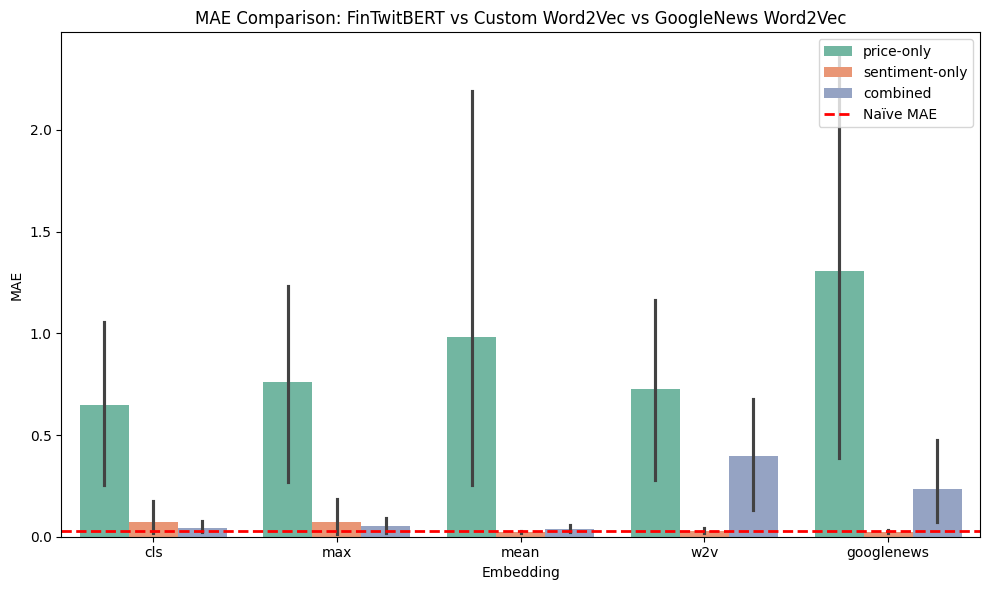

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by average MAE
mae_order = result_df.groupby("Embedding")["MAE"].mean().sort_values().index.tolist()

# Plot MAE bar chart
naive_mae = 0.02621

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=result_df,
    x="Embedding",
    y="MAE",
    hue="FeatureSet",
    order=mae_order,
    palette="Set2"
)

# Add red dashed baseline
plt.axhline(y=naive_mae, color="red", linestyle="--", linewidth=2, label="Naïve MAE")
plt.legend(loc="upper right")

plt.title("MAE Comparison: FinTwitBERT vs Custom Word2Vec vs GoogleNews Word2Vec")
plt.tight_layout()

# Find the best MAE row
min_row = result_df.loc[result_df["MAE"].idxmin()]
label = f"🏆 {min_row['Model']} + {min_row['Embedding']} ({min_row['FeatureSet']})"

# Get hue labels in correct order
hue_order = result_df["FeatureSet"].unique().tolist()

# Loop through bar patches and find match
for bar, (i, row) in zip(ax.patches, result_df.iterrows()):
    if (
        row["Embedding"] == min_row["Embedding"] and
        row["FeatureSet"] == min_row["FeatureSet"] and
        abs(row["MAE"] - min_row["MAE"]) < 1e-6
    ):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            label,
            ha="center",
            va="bottom",
            fontsize=10,
            weight="bold",
            color="black"
        )
        break

plt.savefig("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/mae_comparison_annotated.png")
plt.show()



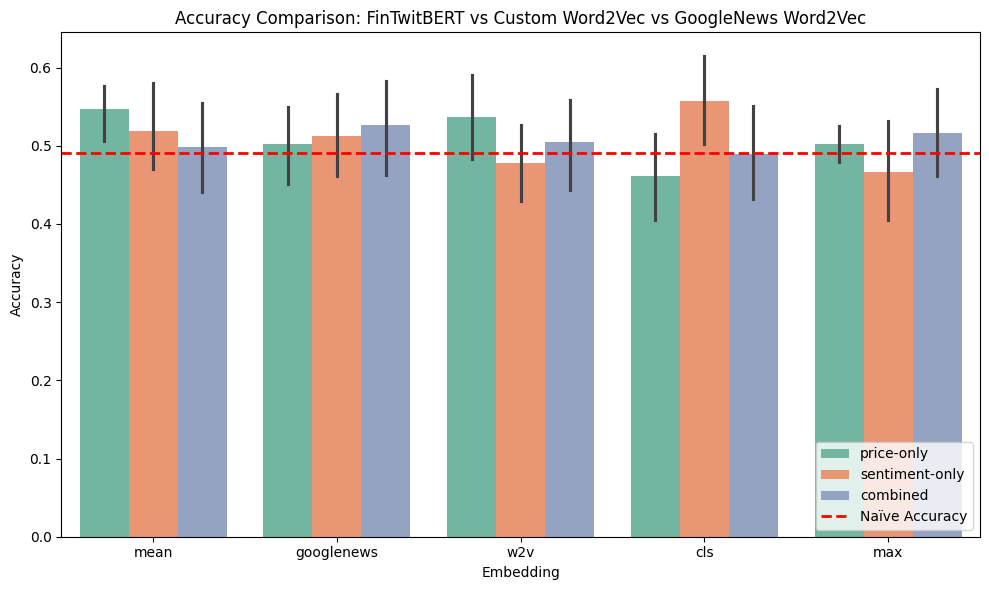

In [35]:
# Accuracy Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Sort embeddings by average Accuracy (highest to lowest for left-to-right)
accuracy_order = result_df.groupby("Embedding")["Accuracy"].mean().sort_values(ascending=False).index.tolist()

# Plot Accuracy bar chart
naive_accuracy = 0.4905

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=result_df,
    x="Embedding",
    y="Accuracy",
    hue="FeatureSet",
    order=accuracy_order,
    palette="Set2"
)

# Add red dashed baseline
plt.axhline(y=naive_accuracy, color="red", linestyle="--", linewidth=2, label="Naïve Accuracy")
plt.legend(loc="lower right")

plt.title("Accuracy Comparison: FinTwitBERT vs Custom Word2Vec vs GoogleNews Word2Vec")
plt.tight_layout()

# 🏆 Find the best Accuracy row
best_row = result_df.loc[result_df["Accuracy"].idxmax()]
label = f"🏆 {best_row['Model']} + {best_row['Embedding']} ({best_row['FeatureSet']})"

# Loop through bar patches and match row exactly
for bar, (i, row) in zip(ax.patches, result_df.iterrows()):
    if (
        row["Embedding"] == best_row["Embedding"] and
        row["FeatureSet"] == best_row["FeatureSet"] and
        abs(row["Accuracy"] - best_row["Accuracy"]) < 1e-6
    ):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            label,
            ha="center",
            va="bottom",
            fontsize=10,
            weight="bold",
            color="black"
        )
        break

# Save with correct filename
plt.savefig("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/accuracy_comparison_annotated.png")
plt.show()

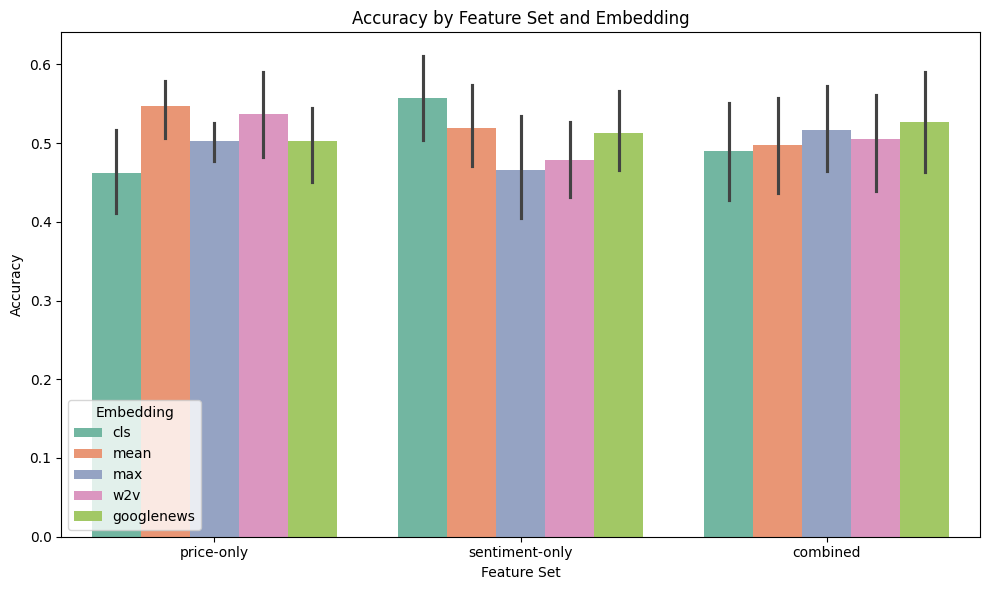

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=result_df,
    x="FeatureSet",
    y="Accuracy",
    hue="Embedding",
    palette="Set2"
)

plt.title("Accuracy by Feature Set and Embedding")
plt.ylabel("Accuracy")
plt.xlabel("Feature Set")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/grouped_accuracy_by_feature.png")
plt.show()

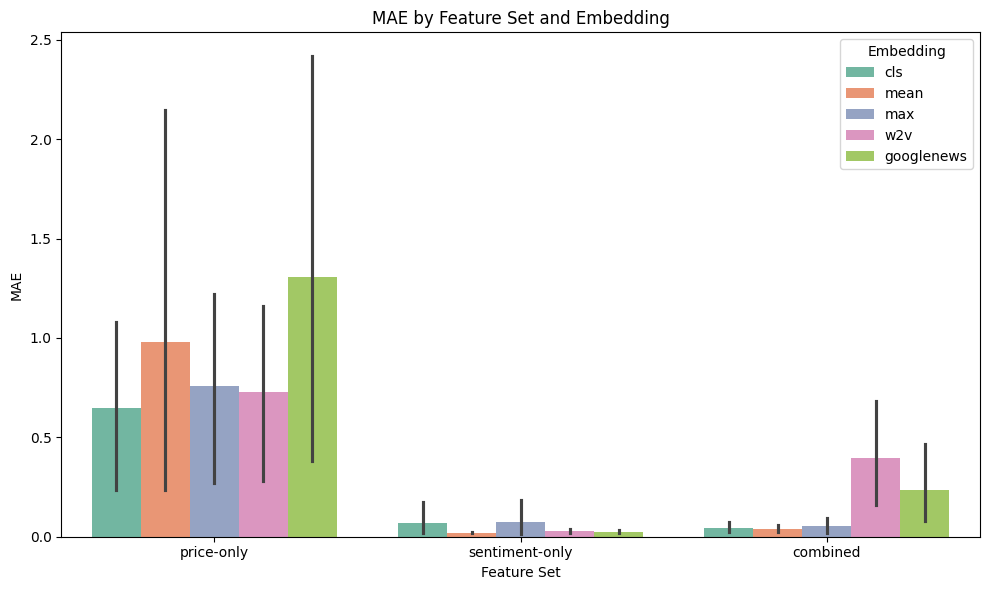

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=result_df,
    x="FeatureSet",
    y="MAE",
    hue="Embedding",
    palette="Set2"
)

plt.title("MAE by Feature Set and Embedding")
plt.ylabel("MAE")
plt.xlabel("Feature Set")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/grouped_mae_by_feature.png")
plt.show()


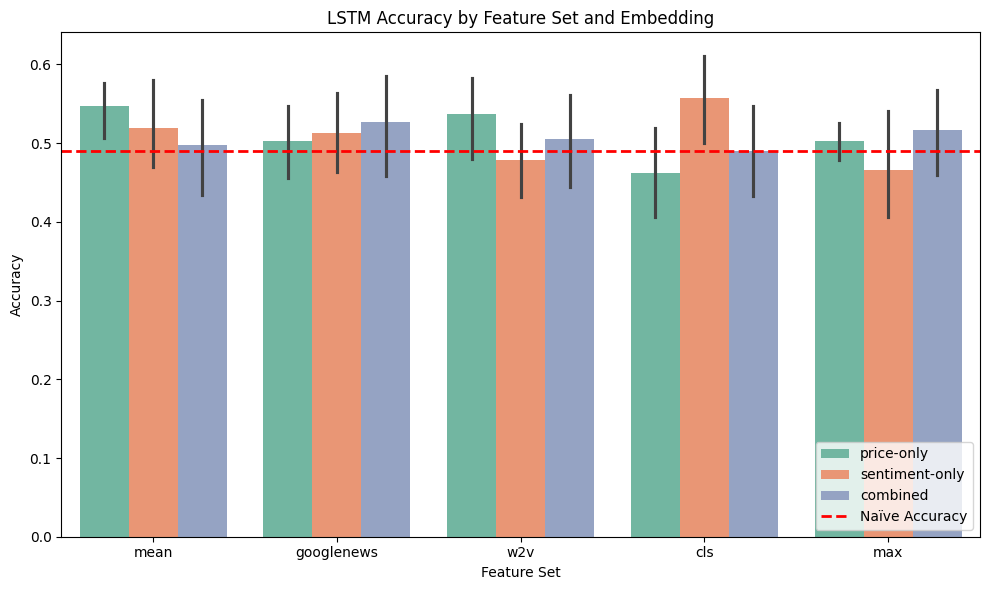

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter result_df for just the LSTM model
lstm_df = result_df[result_df["Model"] == "LSTM"]

# Plot Accuracy bar chart
naive_accuracy = 0.4905

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=result_df,
    x="Embedding",
    y="Accuracy",
    hue="FeatureSet",
    order=accuracy_order,
    palette="Set2"
)

# Add red dashed baseline
plt.axhline(y=naive_accuracy, color="red", linestyle="--", linewidth=2, label="Naïve Accuracy")
plt.legend(loc="lower right")

plt.title("LSTM Accuracy by Feature Set and Embedding")
plt.ylabel("Accuracy")
plt.xlabel("Feature Set")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/lstm_grouped_accuracy_by_feature.png")
plt.show()

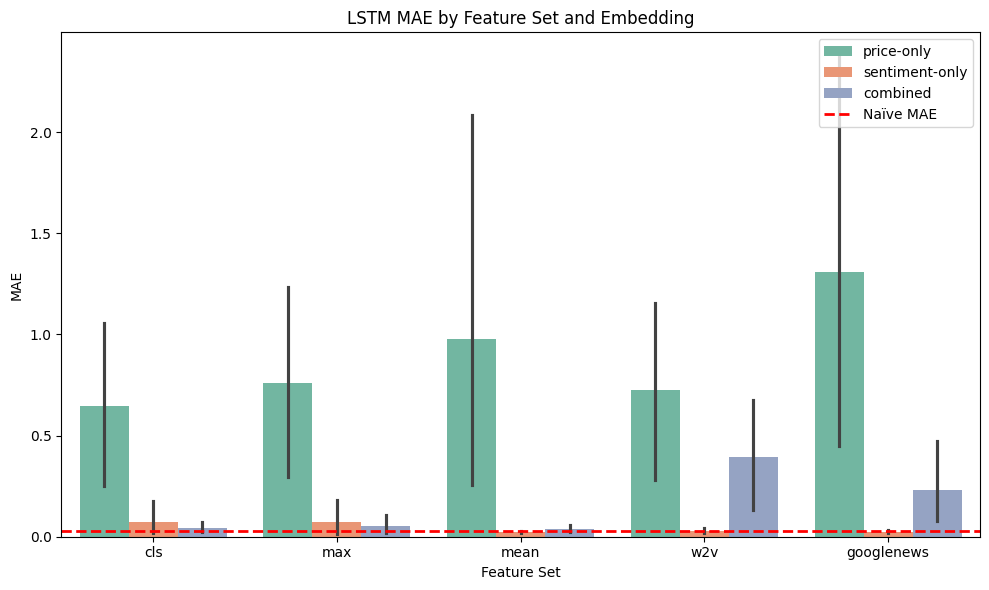

In [39]:
# Filter result_df for just the LSTM model
lstm_df = result_df[result_df["Model"] == "LSTM"]

# Plot MAE bar chart
naive_mae = 0.02621

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=result_df,
    x="Embedding",
    y="MAE",
    hue="FeatureSet",
    order=mae_order,
    palette="Set2"
)

# Add red dashed baseline
plt.axhline(y=naive_mae, color="red", linestyle="--", linewidth=2, label="Naïve MAE")
plt.legend(loc="upper right")

plt.title("LSTM MAE by Feature Set and Embedding")
plt.ylabel("MAE")
plt.xlabel("Feature Set")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/lstm_grouped_mae_by_feature.png")
plt.show()

##Step 2: Summary Table

In [22]:
# Create summary by model and embedding
summary = result_df.groupby(["Model", "Embedding", "FeatureSet"])[["MAE", "Accuracy"]].mean().reset_index()

# Save to CSV
summary_path = "/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/summary_metrics.csv"
summary.to_csv(summary_path, index=False)

# Display summary
print("✅ Summary table saved at:", summary_path)
print(summary)


✅ Summary table saved at: /content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/summary_metrics.csv
    Model   Embedding      FeatureSet       MAE  Accuracy
0   DENSE         cls        combined  0.067006  0.546610
1   DENSE         cls      price-only  1.199891  0.440678
2   DENSE         cls  sentiment-only  0.121286  0.572034
3   DENSE  googlenews        combined  0.403552  0.495098
4   DENSE  googlenews      price-only  2.515956  0.509804
5   DENSE  googlenews  sentiment-only  0.027697  0.465686
6   DENSE         max        combined  0.090168  0.487288
7   DENSE         max      price-only  1.433512  0.500000
8   DENSE         max  sentiment-only  0.126106  0.415254
9   DENSE        mean        combined  0.053344  0.478814
10  DENSE        mean      price-only  1.832954  0.525424
11  DENSE        mean  sentiment-only  0.022791  0.559322
12  DENSE         w2v        combined  0.701449  0.495098
13  DENSE         w2v      price-only  1.348958  0.534314
14  DENSE     

In [2]:
def rerun_missing_embeddings(combined, result_df, feature_modes, models, window, binary=False):
    from sklearn.metrics import mean_absolute_error, accuracy_score

    def safe_stack(vectors, expected_dim):
        clean = [np.array(v) for v in vectors if isinstance(v, (list, np.ndarray)) and len(v) == expected_dim]
        return np.stack(clean) if clean else np.empty((0, expected_dim))

    def create_sequences(df, sentiment_key, mode="combined"):
        expected_dim = 300 if sentiment_key == "googlenews" else 100
        sentiment = safe_stack(df[sentiment_key].dropna().values, expected_dim)
        if sentiment.shape[0] < window:
            raise ValueError(f"⚠️ Not enough valid vectors for {sentiment_key}")

        price = df.select_dtypes(include=[np.number]).drop(columns=["Return", "Next_Close", "avg_sentiment"], errors="ignore").values
        scaler = StandardScaler()
        price_scaled = scaler.fit_transform(price)

        if mode == "price-only":
            X_full = price_scaled
        elif mode == "sentiment-only":
            X_full = sentiment
        else:
            sentiment_feat = sentiment
            if "avg_sentiment" in df:
                sentiment_feat = np.concatenate([sentiment, df[["avg_sentiment"]].values[:len(sentiment)]], axis=1)
            X_full = np.concatenate([sentiment_feat, price_scaled[:len(sentiment)]], axis=1)

        X_seq, y = [], []
        for i in range(len(X_full) - window - 1):
            X_seq.append(X_full[i:i+window])
            y_val = df["Return"].iloc[i + window]
            y.append(int(y_val > 0) if binary else y_val)

        return np.array(X_seq), np.array(y)

    def build_dense(input_shape):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(1 if not binary else 1, activation='sigmoid' if binary else None)
        ])

    def build_lstm(input_shape):
        return tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.LSTM(32, dropout=0.2),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1 if not binary else 1, activation='sigmoid' if binary else None)
        ])

    new_results = []

    for feature_mode in feature_modes:
        for embedding_key in ["w2v", "googlenews"]:
            for model_type in models:
                for ticker in tqdm(combined["Ticker"].unique(), desc=f"{embedding_key} | {feature_mode} | {model_type}"):
                    df_t = combined[combined["Ticker"] == ticker]
                    try:
                        X_seq, y = create_sequences(df_t, embedding_key, mode=feature_mode)
                        if len(X_seq) < 50:
                            continue
                        split = int(0.8 * len(X_seq))
                        X_train, X_test = X_seq[:split], X_seq[split:]
                        y_train, y_test = y[:split], y[split:]

                        if model_type == "dense":
                            X_train_flat = X_train.reshape(X_train.shape[0], -1)
                            X_test_flat = X_test.reshape(X_test.shape[0], -1)
                            model = build_dense(X_train_flat.shape[1])
                            X_tr, X_te = X_train_flat, X_test_flat
                        else:
                            model = build_lstm(X_train.shape[1:])
                            X_tr, X_te = X_train, X_test

                        model.compile(optimizer='adam', loss='mae')
                        model.fit(X_tr, y_train, epochs=10, batch_size=32, verbose=0)
                        y_pred = model.predict(X_te).flatten()

                        mae = mean_absolute_error(y_test, y_pred)
                        acc = accuracy_score(y_test > 0, y_pred > 0)

                        new_results.append({
                            "Model": model_type.upper(),
                            "Embedding": embedding_key,
                            "FeatureSet": feature_mode,
                            "MAE": mae,
                            "Accuracy": acc
                        })

                    except Exception as e:
                        print(f"❌ {ticker} failed for {embedding_key}: {e}")

    return pd.concat([result_df, pd.DataFrame(new_results)], ignore_index=True)

In [3]:
result_df = rerun_missing_embeddings(
    combined=combined,
    result_df=result_df,
    feature_modes=["price-only", "sentiment-only", "combined"],
    models=["dense", "lstm"],
    window=10,
    binary=False
)
result_df.to_csv("/content/drive/MyDrive/DataSci266_Final_Project/combined_lstm_results/final_model_comparison_all_embeddings.csv", index=False)

NameError: name 'combined' is not defined

## Step 3: Bar Charts

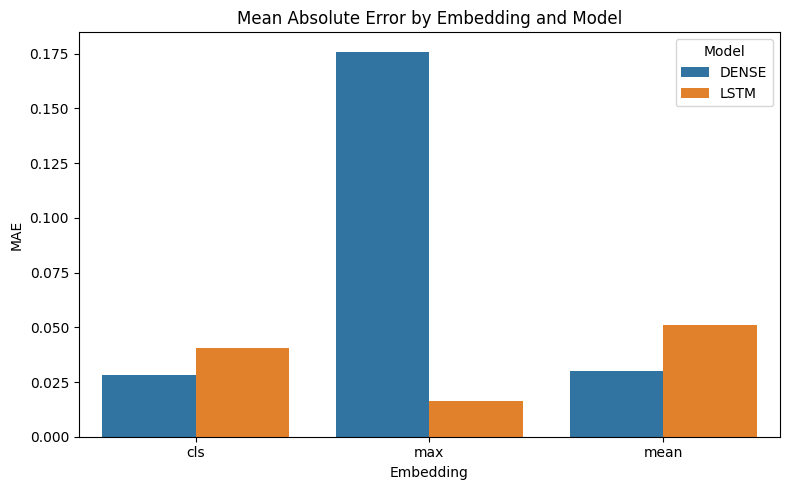

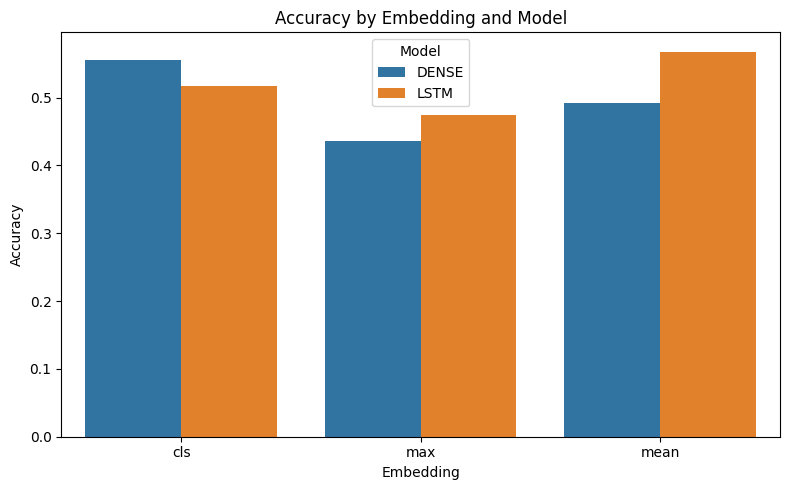

In [24]:
# Bar plot - MAE
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x="Embedding", y="MAE", hue="Model")
plt.title("Mean Absolute Error by Embedding and Model")
plt.tight_layout()
plt.savefig(f"{results_dir}/bar_mae.png")
plt.show()

# Bar plot - Accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x="Embedding", y="Accuracy", hue="Model")
plt.title("Accuracy by Embedding and Model")
plt.tight_layout()
plt.savefig(f"{results_dir}/bar_accuracy.png")
plt.show()
